In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

import cv2
import pygmsh
import os

spatial_scale = 1e3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
from data_processing import *
from yearly_pbnn import *
from skimage.morphology import erosion, dilation, disk

def make_mesh(county, eps=1e-3, mesh_size=5, dilate=4):
    save_path = f'yearly/processed/{county}_mesh.xml'
    load_path = f'yearly/processed/{county}.hdf5'

    with h5py.File(load_path, 'r') as h5f:
        d = h5f['2010']
        mask = d['mask'][:].astype(bool)
        x_grid = d['x_grid'][:] / spatial_scale
        y_grid = d['y_grid'][:] / spatial_scale

    mask_float = np.zeros(mask.shape, dtype=np.uint8)
    mask_float[mask] = 255
    structure = disk(dilate)
    mask_float = dilation(mask_float, structure)
    contours, _ = cv2.findContours(mask_float, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

    '''
    countours is a list of lists -- you can change the index below here to get 
        different contours to choose as the mesh.
    '''
    idx = np.argmax([contours[i].squeeze().shape[0] for i in range(len(contours))])
    polygon = contours[idx].squeeze()
    
    #Simplify contour
    polygon = cv2.approxPolyDP(polygon, eps*cv2.arcLength(polygon, True), True)
    polygon = polygon.squeeze()
    print(polygon.shape)
    
    print(mask.shape, polygon.shape)
    pos_x = x_grid[polygon[:, 1], polygon[:, 0]]
    pos_y = y_grid[polygon[:, 1], polygon[:, 0]]

    with pygmsh.geo.Geometry() as geom:
        geom.add_polygon(np.stack([pos_x, pos_y], axis=-1), mesh_size=mesh_size)
        mesh = geom.generate_mesh(dim=2, verbose=True)
    mesh.points = mesh.points[:, :2]
    mesh.write(save_path)

    print(mesh)

    fig, ax = plt.subplots(1, 2, dpi=200)
    ax[0].pcolormesh(x_grid, y_grid, mask, cmap='Greys_r')
    ax[1].triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells[1].data,
                  color='black', linewidth=0.1)

    for a in ax:
        a.set(xticks=[], yticks=[], title=county, aspect='equal');
    
    try:
        dataset = YearlyDataset(county)
        print('Loaded dataset', flush=True)

        model = SourcedOnlyPBNN()
        model.to(device)

        sample = dataset[0]
        sample['wb0'] = sample['wb0'].to(device)

        loss = model.training_step(sample)[1]
        print(f'Model training step {loss:.3g}')
        if np.isnan(loss):
            print('Loss is bad -- removing mesh from library')
            os.remove(save_path)
        else:
            print('Mesh is alright')
    except Exception as e:
        print(e)
        print('Removing mesh from library')
        os.remove(save_path)

(40, 2)
(548, 685) (40, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 1759
  Number of cells:
    line: 174
    triangle: 3342
    vertex: 40
(12, 3, 548, 685)
Building dataset with constant housing in time
Loaded dataset
Model training step 619
Mesh is alright


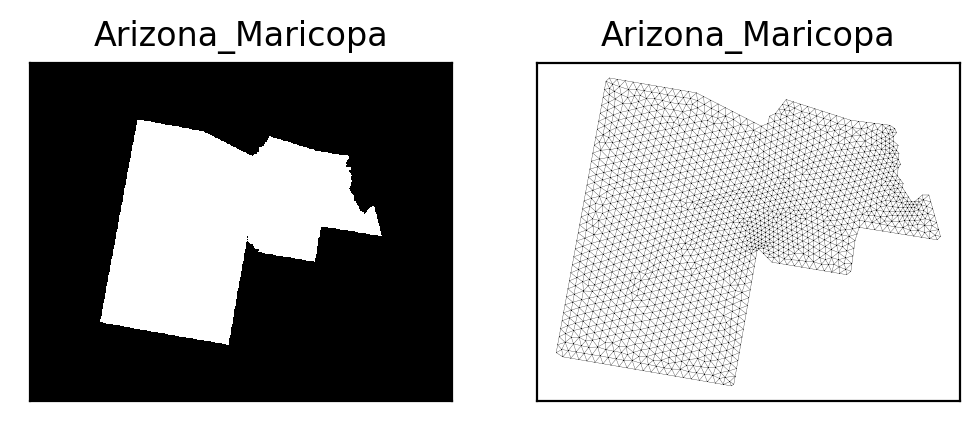

In [3]:
make_mesh('Arizona_Maricopa')

(72, 2)
(194, 199) (72, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 407
  Number of cells:
    line: 86
    triangle: 726
    vertex: 72
(12, 3, 194, 199)
Building dataset with constant housing in time
Loaded dataset
Model training step 5.85
Mesh is alright


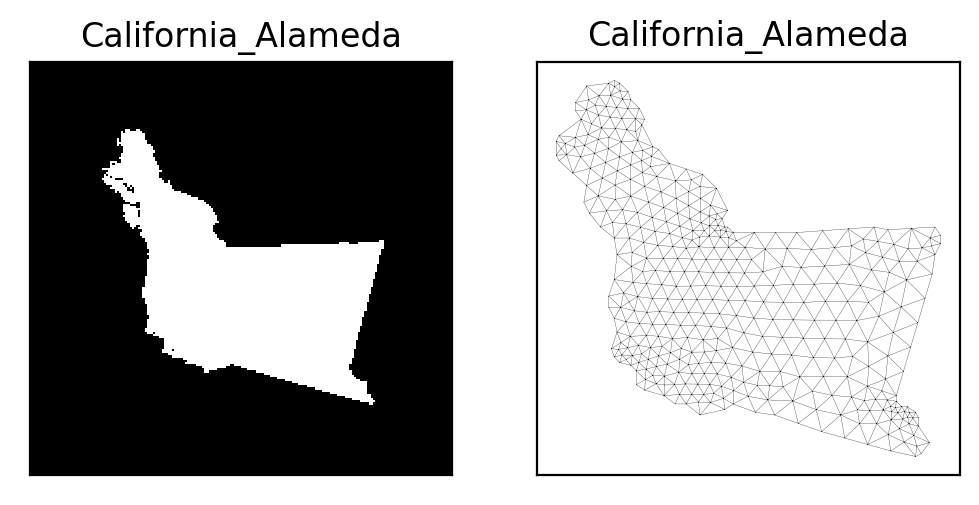

In [4]:
make_mesh('California_Alameda')

(83, 2)
(131, 226) (83, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 649
  Number of cells:
    line: 94
    triangle: 1202
    vertex: 83
(12, 3, 131, 226)
Building dataset with constant housing in time
Loaded dataset
Model training step 1.4
Mesh is alright


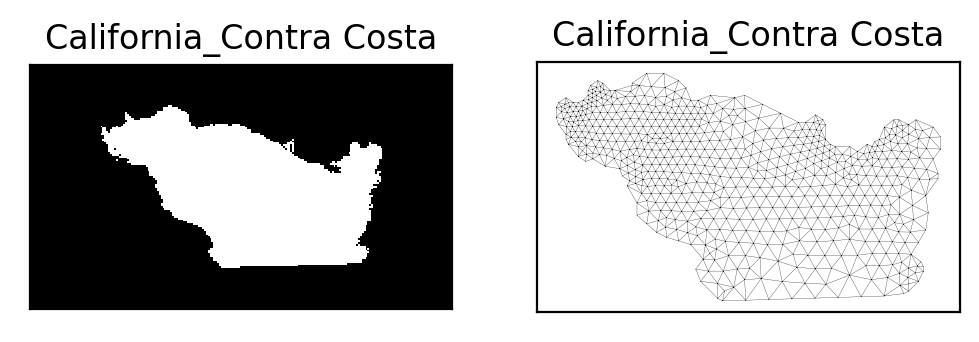

In [5]:
make_mesh('California_Contra Costa')

(73, 2)
(688, 401) (73, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 1022
  Number of cells:
    line: 133
    triangle: 1909
    vertex: 73
(12, 3, 688, 401)
Building dataset with constant housing in time
Loaded dataset
Model training step 0.274
Mesh is alright


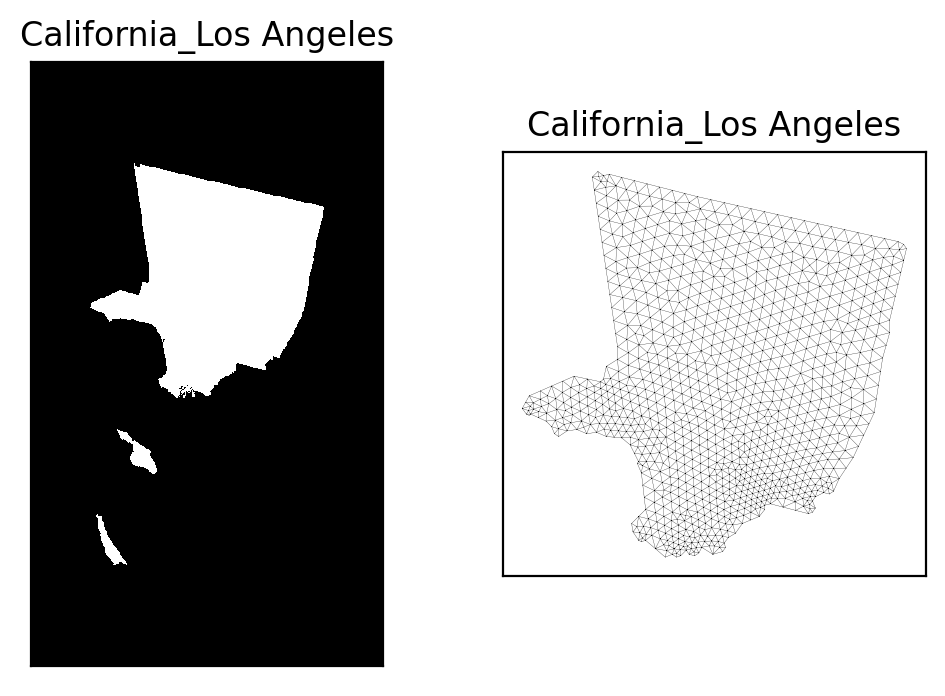

In [6]:
make_mesh('California_Los Angeles')

(65, 2)
(207, 183) (65, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 571
  Number of cells:
    line: 78
    triangle: 1062
    vertex: 65
(12, 3, 207, 183)
Building dataset with constant housing in time
Loaded dataset
Model training step 59
Mesh is alright


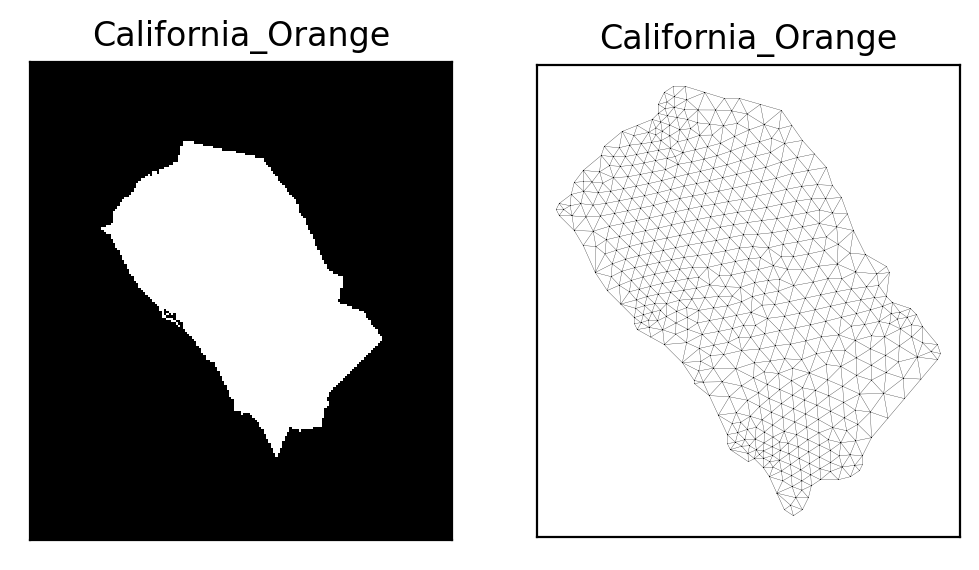

In [7]:
make_mesh('California_Orange')

(51, 2)
(367, 888) (51, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 1334
  Number of cells:
    line: 167
    triangle: 2499
    vertex: 51
(12, 3, 367, 888)
Building dataset with constant housing in time
Loaded dataset
Model training step 384
Mesh is alright


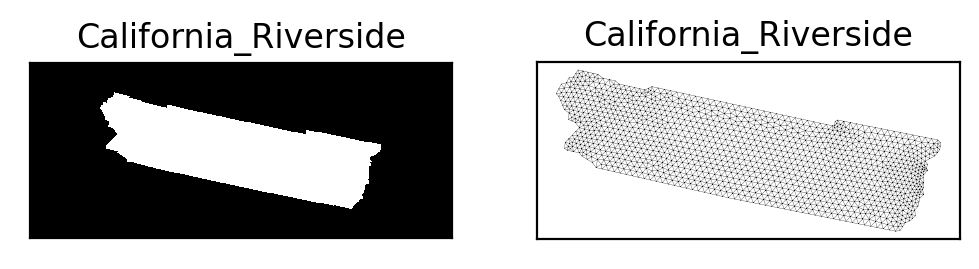

In [8]:
make_mesh('California_Riverside')

(84, 2)
(219, 248) (84, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 602
  Number of cells:
    line: 103
    triangle: 1099
    vertex: 84
(12, 3)
Building dataset with constant housing in time
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Removing mesh from library


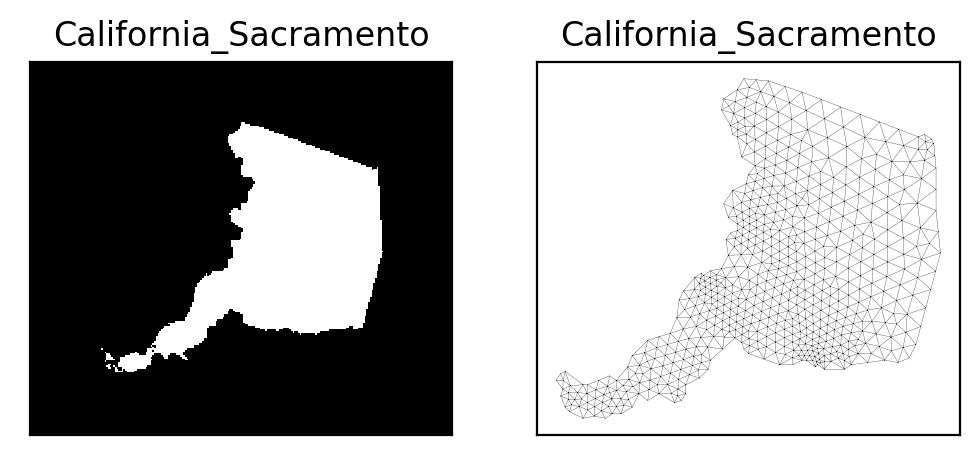

In [9]:
make_mesh('California_Sacramento')

(52, 2)
(746, 1008) (52, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 3085
  Number of cells:
    line: 218
    triangle: 5950
    vertex: 52
(12, 3, 746, 1008)
Building dataset with constant housing in time
Loaded dataset
Model training step 398
Mesh is alright


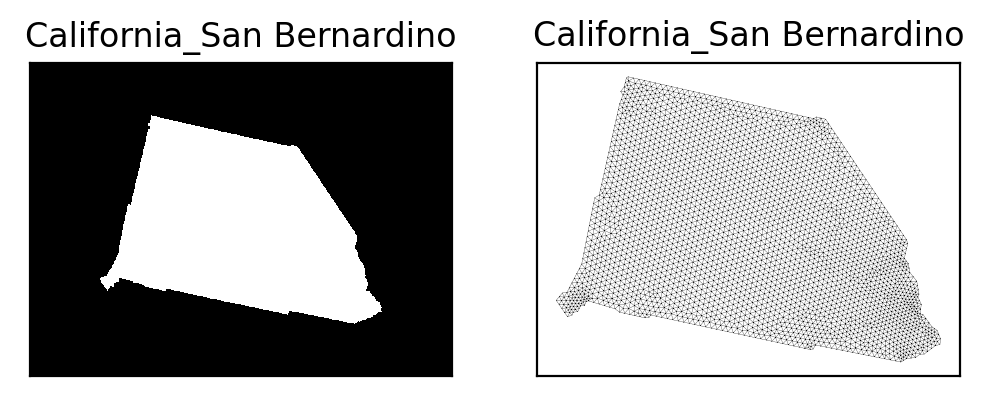

In [10]:
make_mesh('California_San Bernardino')

(57, 2)
(375, 412) (57, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 980
  Number of cells:
    line: 120
    triangle: 1838
    vertex: 57
(12, 3, 375, 412)
Building dataset with constant housing in time
Loaded dataset
Model training step 468
Mesh is alright


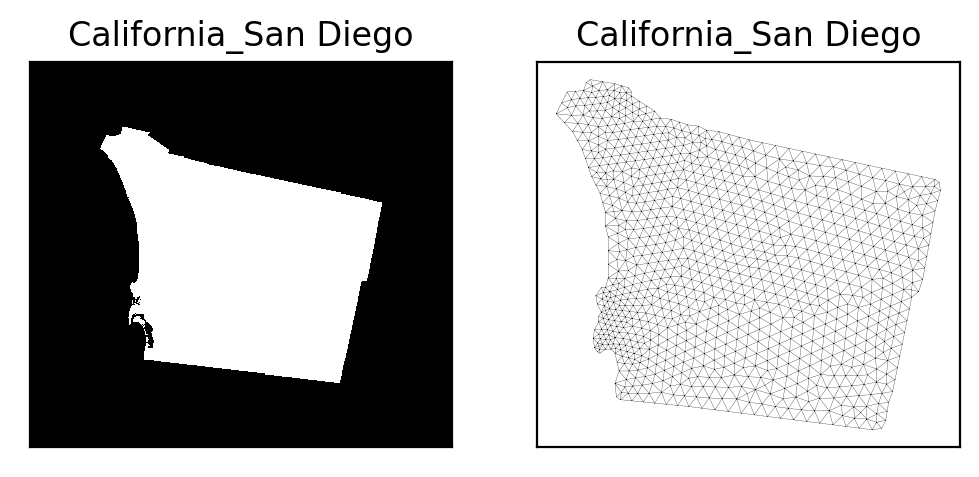

In [11]:
make_mesh('California_San Diego')

(100, 2)
(227, 231) (100, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 905
  Number of cells:
    line: 110
    triangle: 1698
    vertex: 100
(12, 3, 227, 231)
Building dataset with constant housing in time
Loaded dataset
Model training step 3.31
Mesh is alright


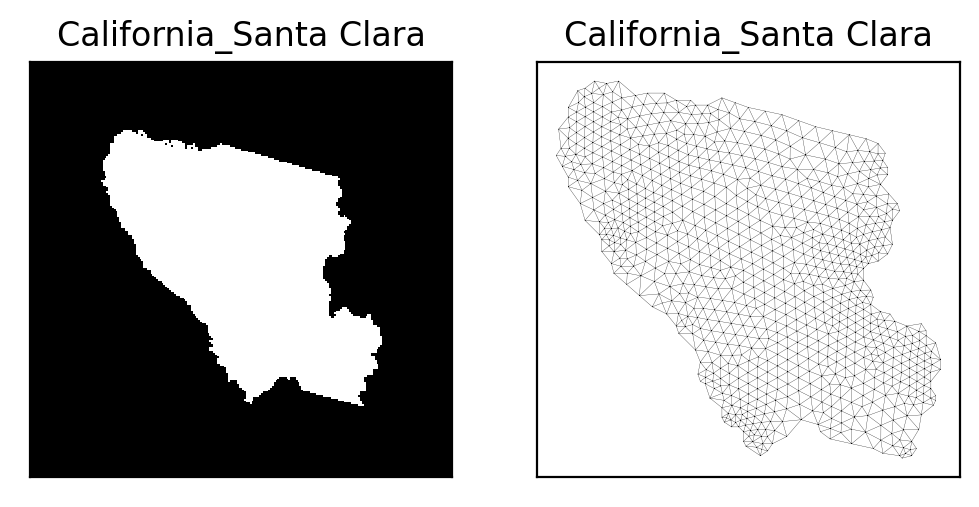

In [12]:
make_mesh('California_Santa Clara')

(44, 2)
(152, 248) (44, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 430
  Number of cells:
    line: 73
    triangle: 785
    vertex: 44
(12, 3, 152, 248)
Building dataset with constant housing in time
Loaded dataset
Model training step 0.0603
Mesh is alright


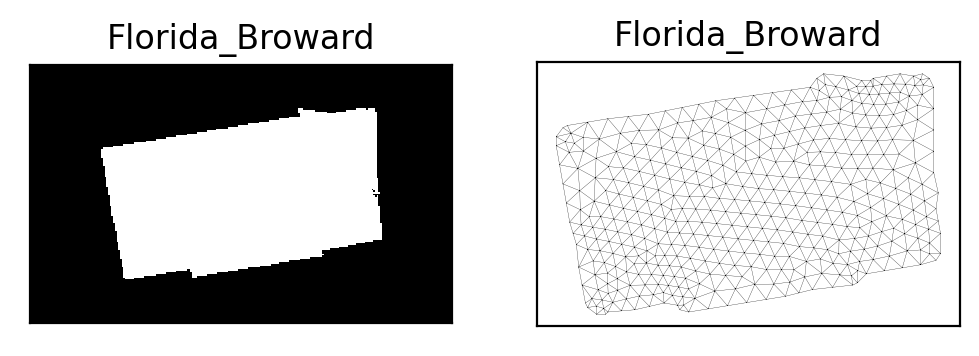

In [13]:
make_mesh('Florida_Broward')

(70, 2)
(225, 208) (70, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 535
  Number of cells:
    line: 99
    triangle: 969
    vertex: 70
(12, 3, 225, 208)
Building dataset with constant housing in time
Loaded dataset
Model training step 105
Mesh is alright


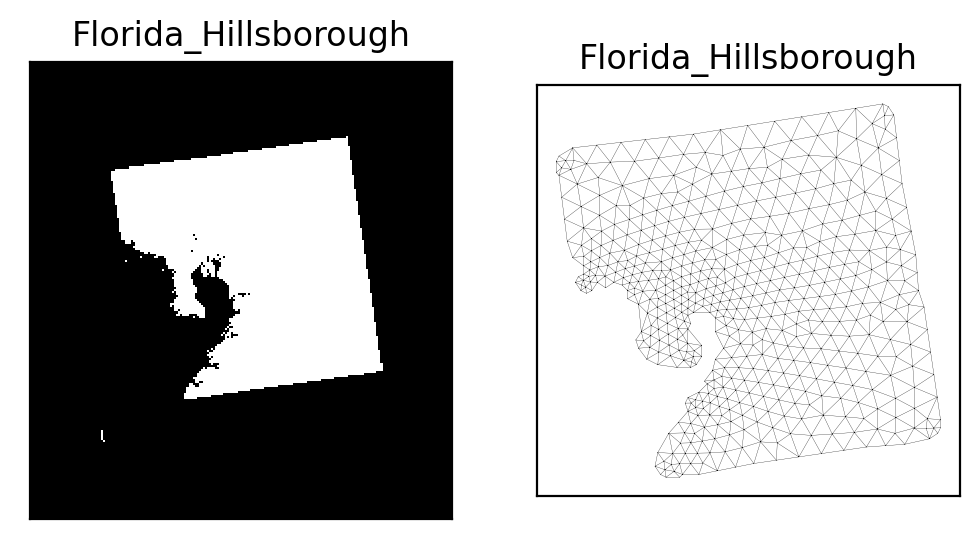

In [14]:
make_mesh('Florida_Hillsborough')

(105, 2)
(305, 236) (105, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 879
  Number of cells:
    line: 137
    triangle: 1619
    vertex: 105
(12, 3, 305, 236)
Building dataset with constant housing in time
Loaded dataset
Model training step 178
Mesh is alright


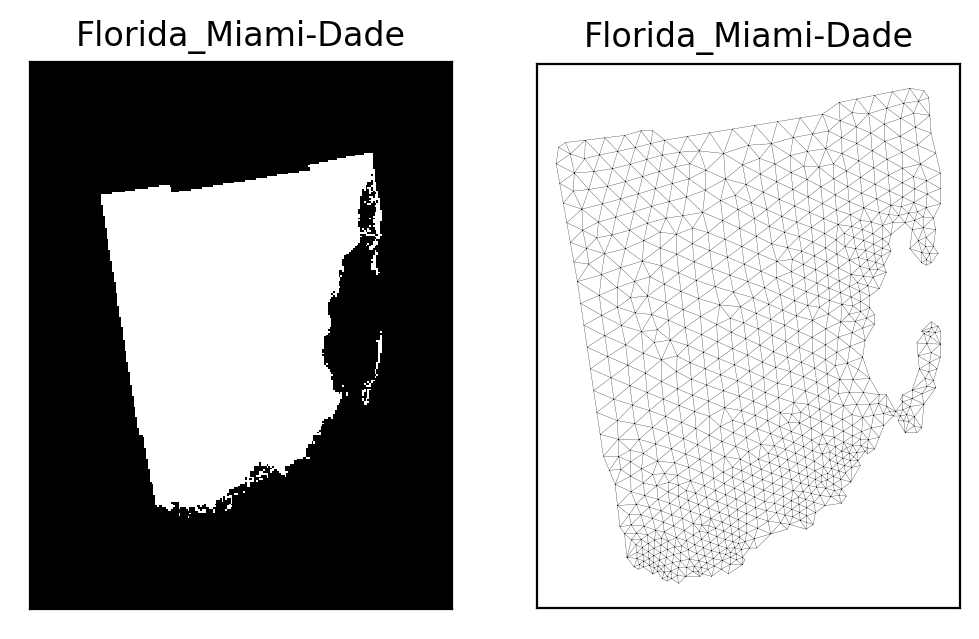

In [15]:
make_mesh('Florida_Miami-Dade')

(40, 2)
(247, 276) (40, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 565
  Number of cells:
    line: 85
    triangle: 1043
    vertex: 40
(12, 3, 247, 276)
Building dataset with constant housing in time
Loaded dataset
Model training step 2.8
Mesh is alright


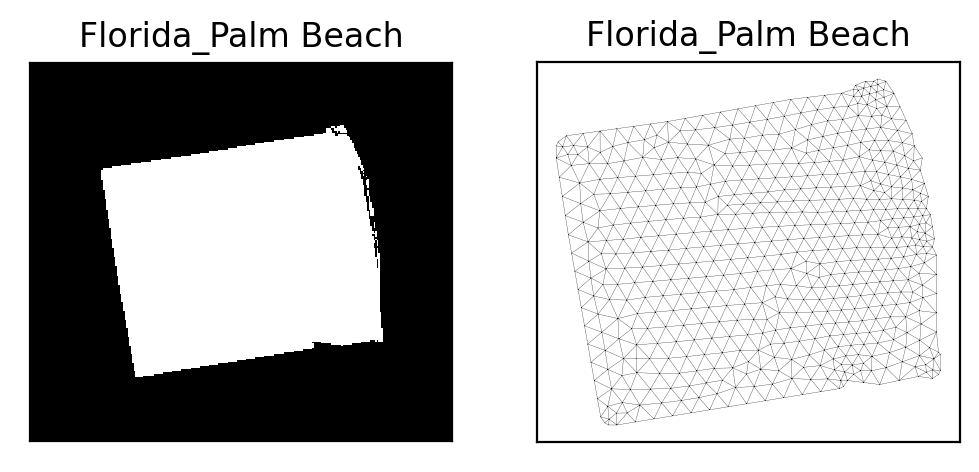

In [16]:
make_mesh('Florida_Palm Beach')

(61, 2)
(229, 200) (61, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 509
  Number of cells:
    line: 89
    triangle: 927
    vertex: 61
(12, 3, 229, 200)
Building dataset with constant housing in time
Loaded dataset
Model training step 68.7
Mesh is alright


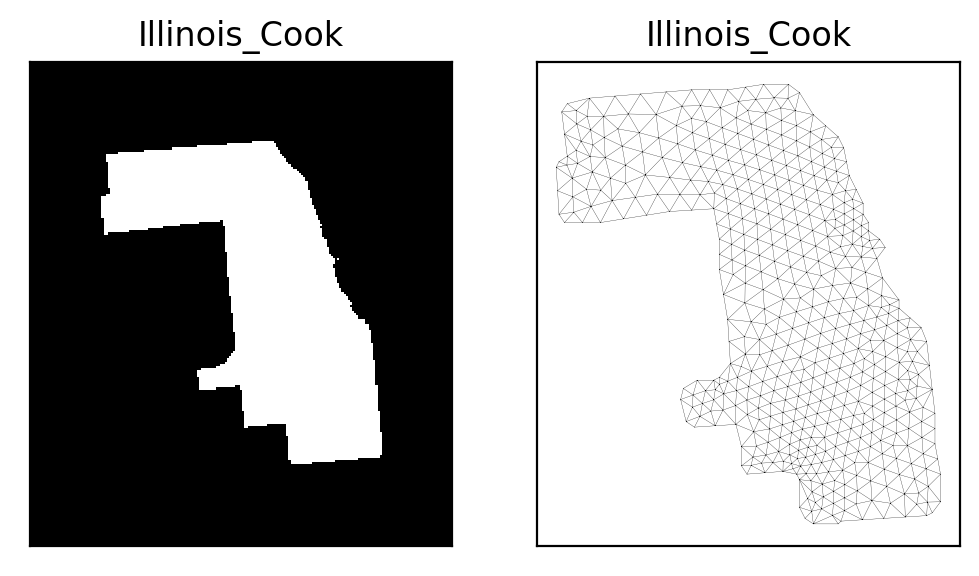

In [17]:
make_mesh('Illinois_Cook')

(101, 2)
(203, 232) (101, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 901
  Number of cells:
    line: 113
    triangle: 1687
    vertex: 101
(12, 3)
Building dataset with constant housing in time
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Removing mesh from library


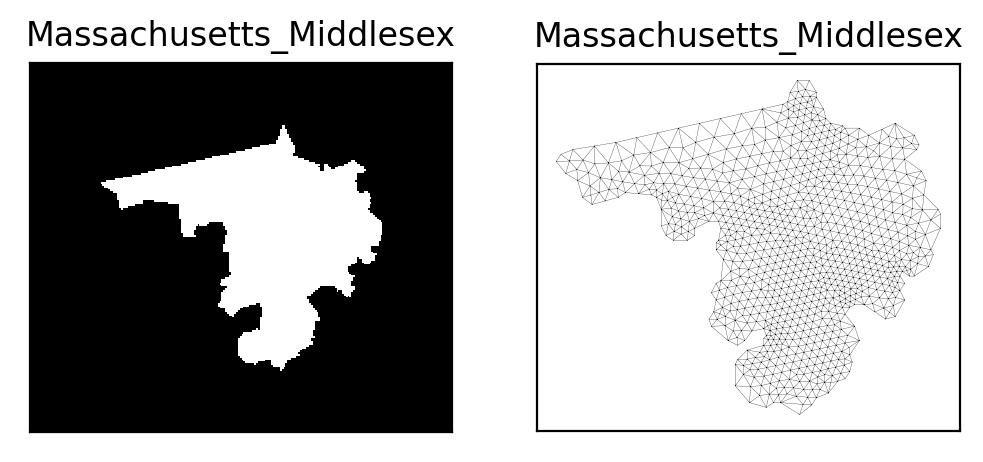

In [18]:
make_mesh('Massachusetts_Middlesex')

(26, 2)
(171, 166) (26, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 537
  Number of cells:
    line: 81
    triangle: 991
    vertex: 26
(12, 3, 171, 166)
Building dataset with constant housing in time
Loaded dataset
Model training step 144
Mesh is alright


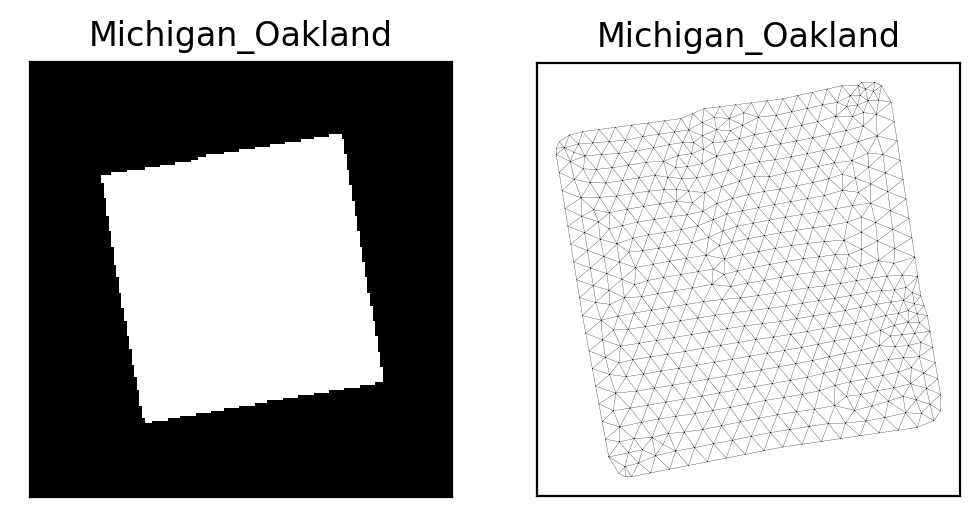

In [19]:
make_mesh('Michigan_Oakland', mesh_size=3)

(49, 2)
(151, 166) (49, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 538
  Number of cells:
    line: 91
    triangle: 983
    vertex: 49
(12, 3, 151, 166)
Building dataset with constant housing in time
Loaded dataset
Model training step 46
Mesh is alright


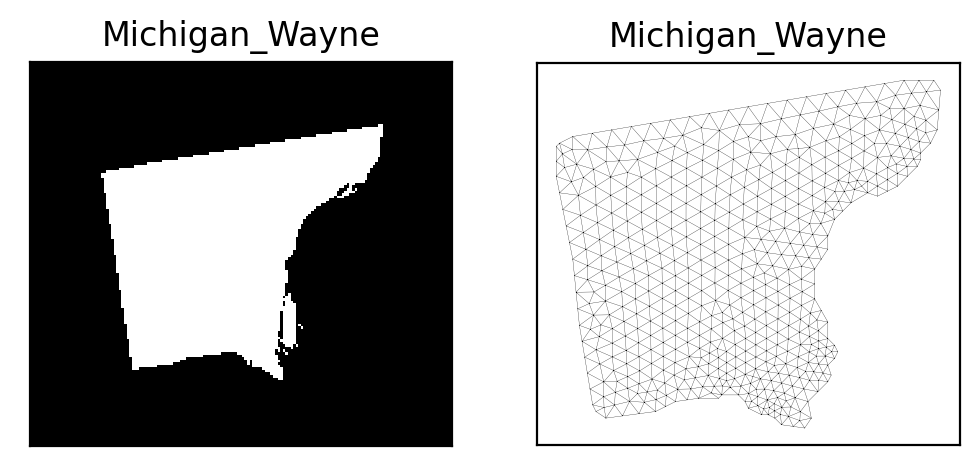

In [20]:
make_mesh('Michigan_Wayne', mesh_size=3)

(65, 2)
(154, 141) (65, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 443
  Number of cells:
    line: 75
    triangle: 809
    vertex: 65
(12, 3, 154, 141)
Building dataset with constant housing in time
Loaded dataset
Model training step 23
Mesh is alright


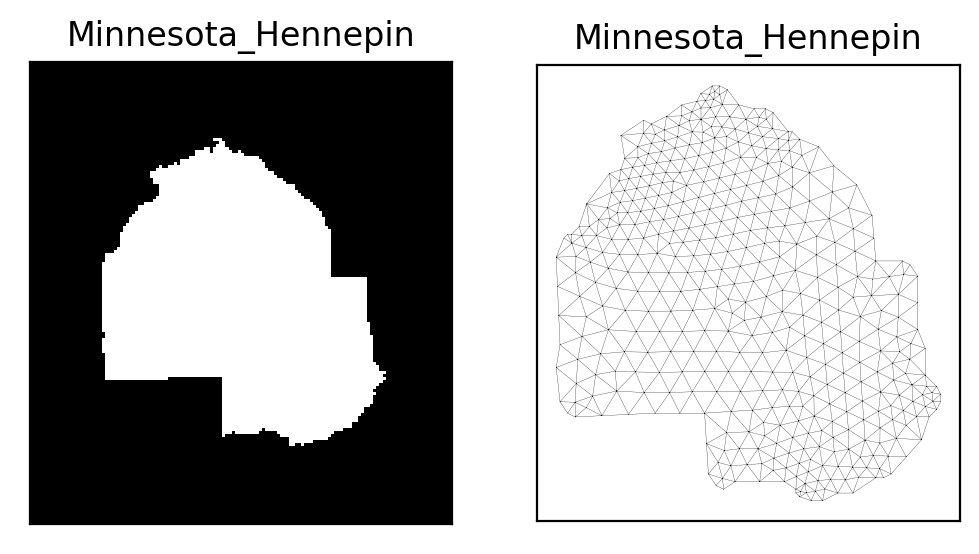

In [21]:
make_mesh('Minnesota_Hennepin')

(54, 2)
(674, 528) (54, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 1604
  Number of cells:
    line: 166
    triangle: 3040
    vertex: 54
(12, 3, 674, 528)
Building dataset with constant housing in time
Loaded dataset
Model training step 614
Mesh is alright


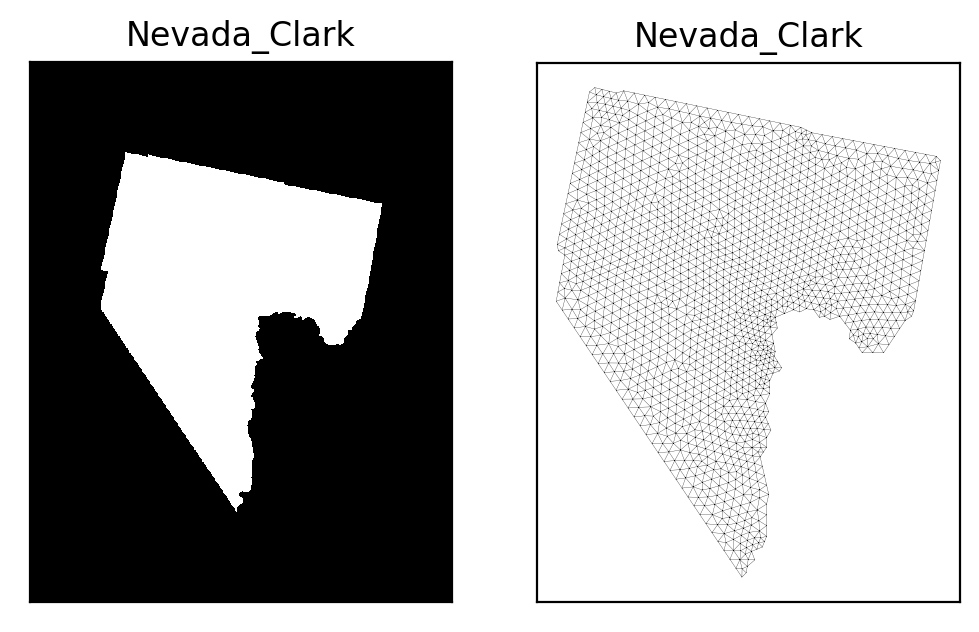

In [22]:
make_mesh('Nevada_Clark')

(34, 2)
(43, 42) (34, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 352
  Number of cells:
    line: 79
    triangle: 623
    vertex: 34
could not broadcast input array from shape (43,42) into shape (43)
Removing mesh from library


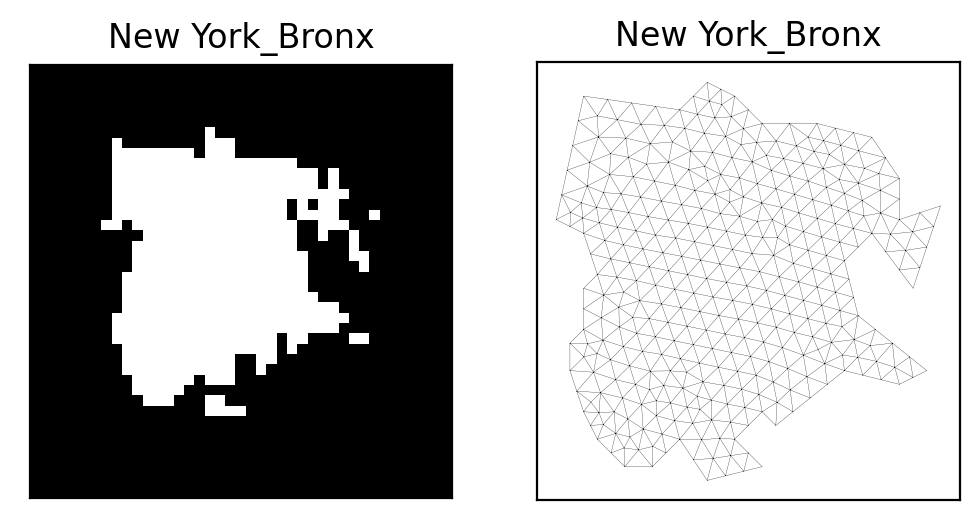

In [23]:
make_mesh('New York_Bronx', dilate=1, mesh_size=1)

(36, 2)
(58, 53) (36, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 513
  Number of cells:
    line: 86
    triangle: 938
    vertex: 36
(12, 3)
Building dataset with constant housing in time
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Removing mesh from library


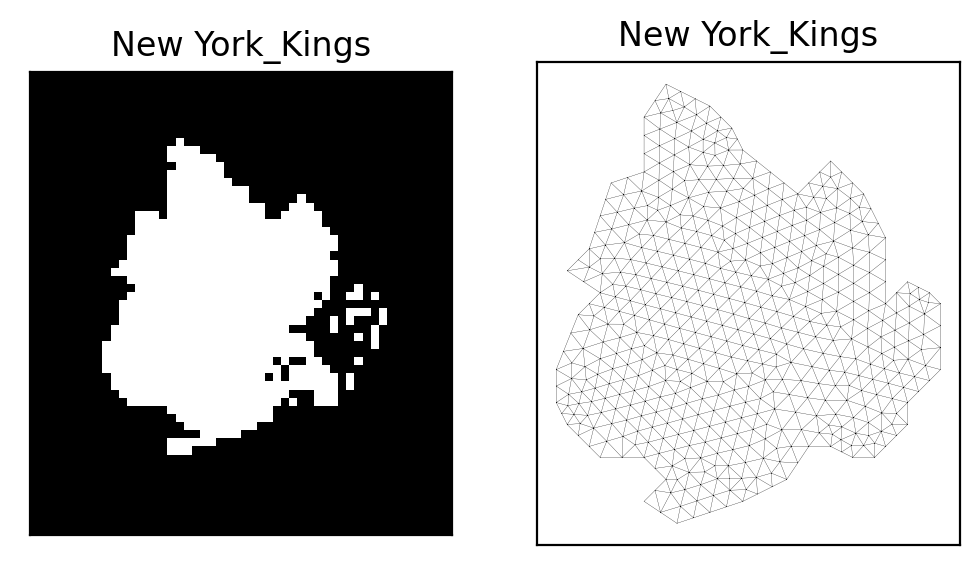

In [24]:
make_mesh('New York_Kings', dilate=1, mesh_size=1)

(60, 2)
(124, 100) (60, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 487
  Number of cells:
    line: 73
    triangle: 899
    vertex: 60
(12, 3, 124, 100)
Building dataset with constant housing in time
Loaded dataset
Model training step 40.5
Mesh is alright


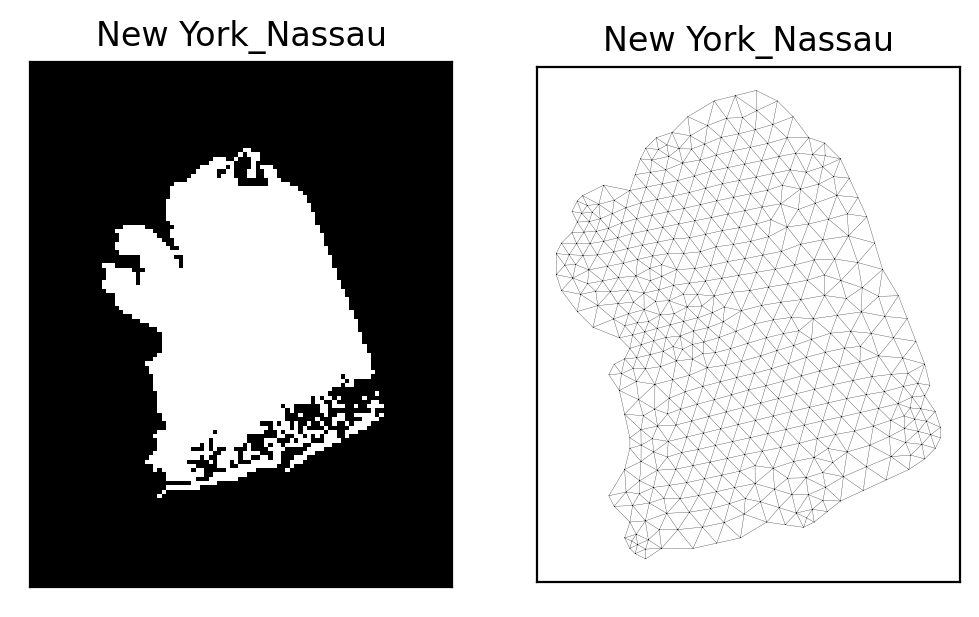

In [25]:
make_mesh('New York_Nassau', mesh_size=3)

(31, 2)
(71, 25) (31, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 524
  Number of cells:
    line: 127
    triangle: 919
    vertex: 31
(12, 3, 71, 25)
Building dataset with constant housing in time
Loaded dataset
Model training step 0.66
Mesh is alright


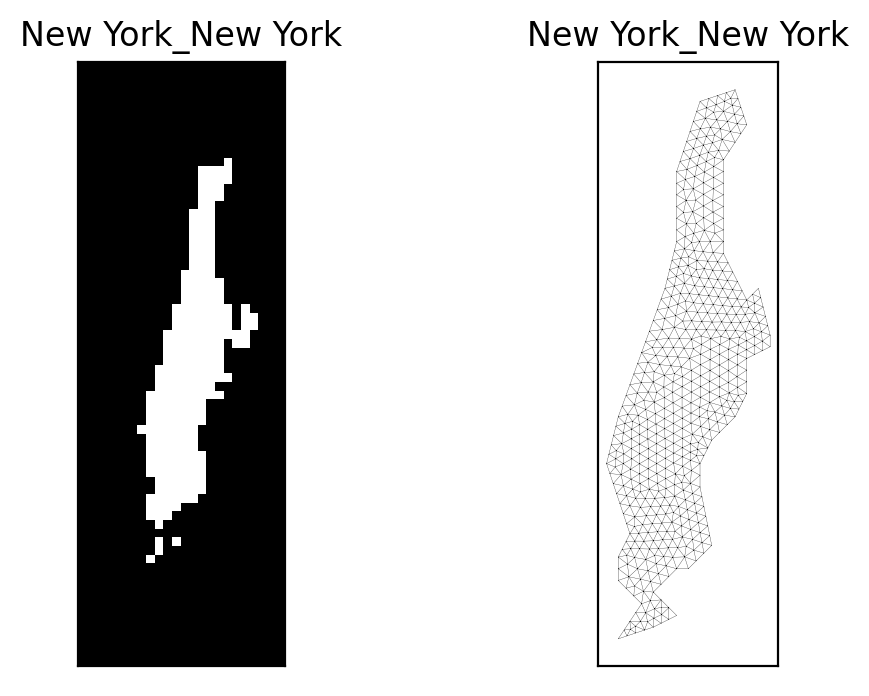

In [26]:
make_mesh('New York_New York', dilate=1, mesh_size=0.5)

(63, 2)
(91, 67) (63, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 454
  Number of cells:
    line: 83
    triangle: 823
    vertex: 63
(12, 3)
Building dataset with constant housing in time
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Removing mesh from library


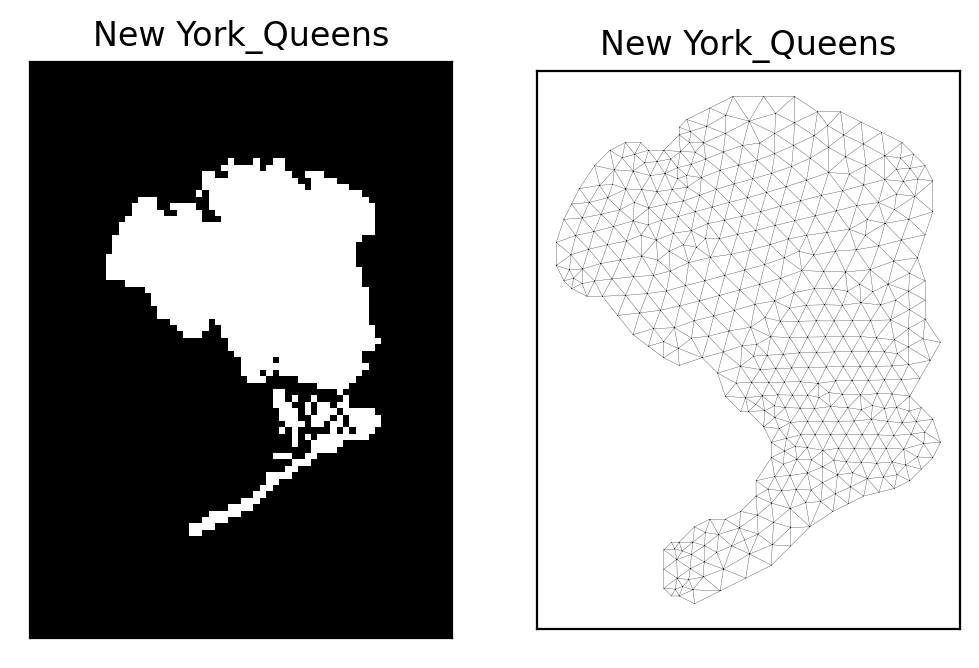

In [27]:
make_mesh('New York_Queens', mesh_size=2)

(88, 2)
(314, 387) (88, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 486
  Number of cells:
    line: 126
    triangle: 844
    vertex: 88
(12, 3, 314, 387)
Building dataset with constant housing in time
Loaded dataset
Model training step 265
Mesh is alright


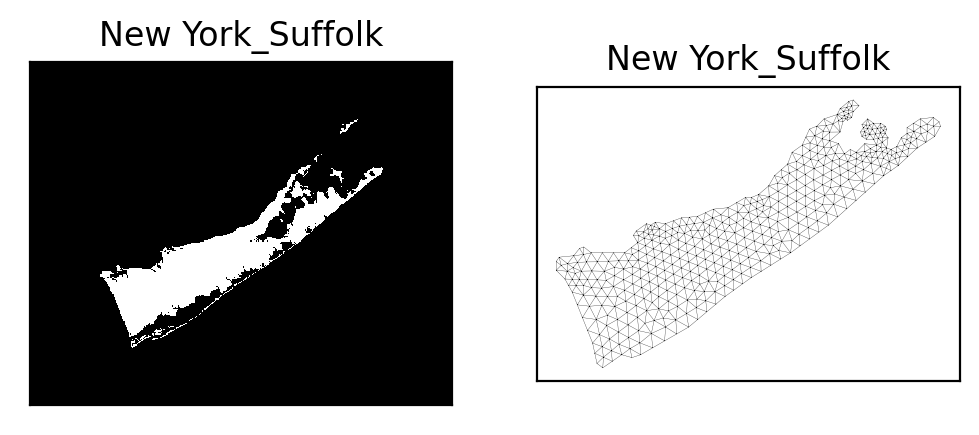

In [28]:
make_mesh('New York_Suffolk')

(64, 2)
(133, 150) (64, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 489
  Number of cells:
    line: 74
    triangle: 902
    vertex: 64
(12, 3, 133, 150)
Building dataset with constant housing in time
Loaded dataset
Model training step 81
Mesh is alright


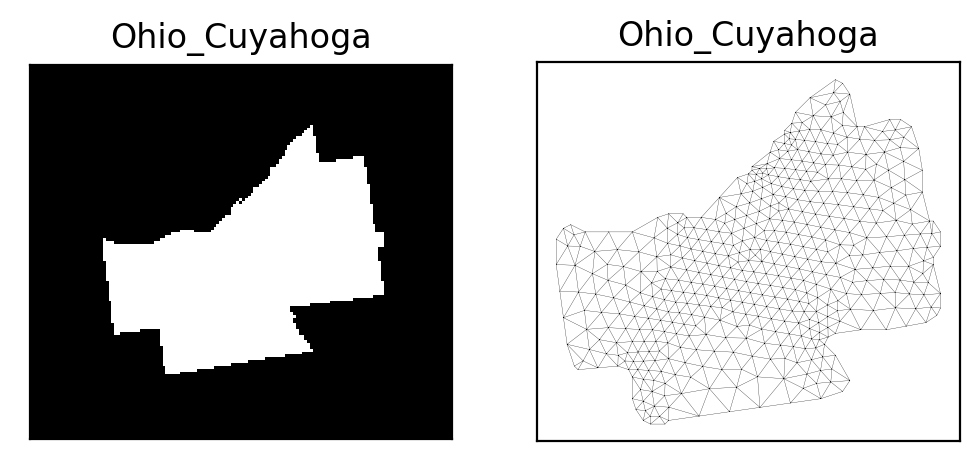

In [29]:
make_mesh('Ohio_Cuyahoga')

(57, 2)
(167, 167) (57, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 431
  Number of cells:
    line: 71
    triangle: 789
    vertex: 57
(12, 3, 167, 167)
Building dataset with constant housing in time
Loaded dataset
Model training step 34
Mesh is alright


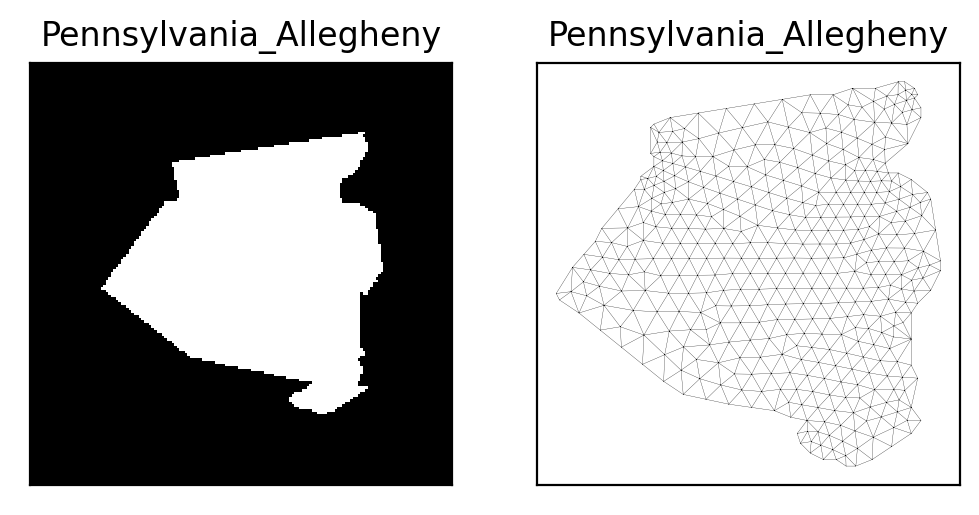

In [30]:
make_mesh('Pennsylvania_Allegheny')

(66, 2)
(100, 74) (66, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 481
  Number of cells:
    line: 88
    triangle: 872
    vertex: 66
(12, 3, 100, 74)
Building dataset with constant housing in time
Loaded dataset
Model training step 2.6
Mesh is alright


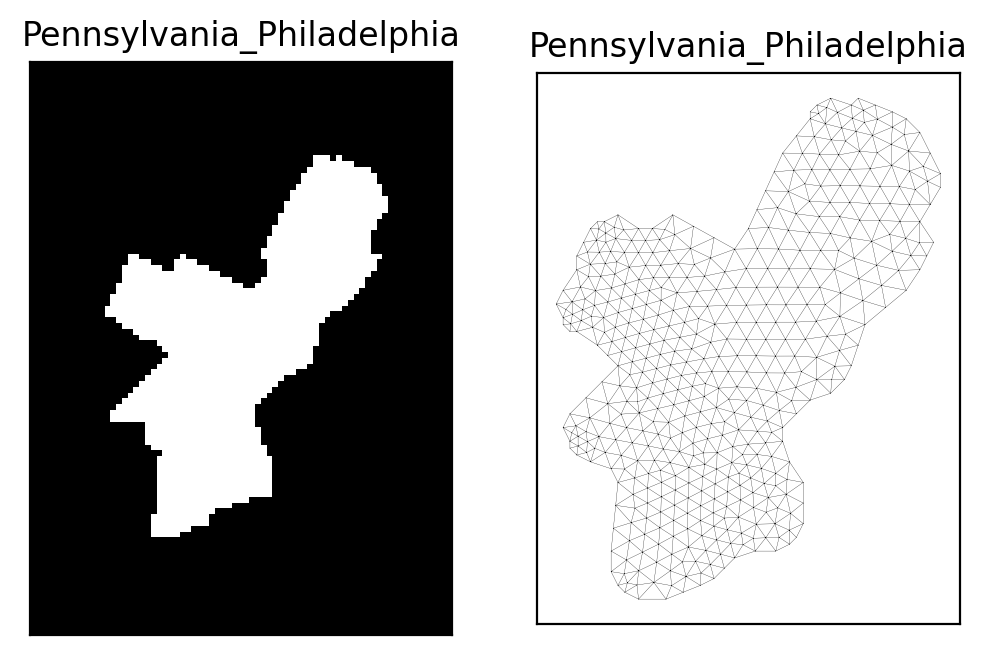

In [31]:
make_mesh('Pennsylvania_Philadelphia', dilate=4, eps=5e-4, mesh_size=2)

(60, 2)
(216, 203) (60, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 504
  Number of cells:
    line: 83
    triangle: 923
    vertex: 60
(12, 3, 216, 203)
Building dataset with constant housing in time
Loaded dataset
Model training step 77.6
Mesh is alright


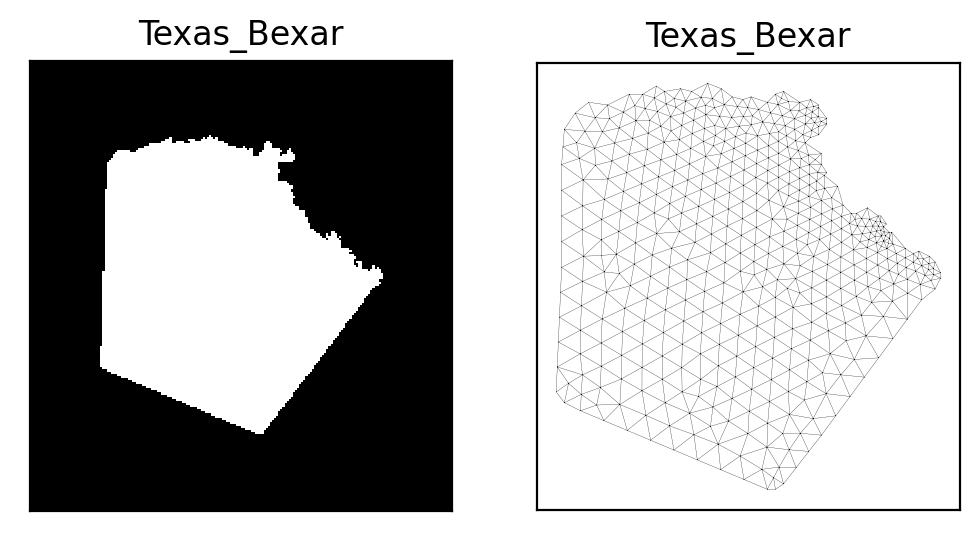

In [32]:
make_mesh('Texas_Bexar')

(16, 2)
(150, 147) (16, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 456
  Number of cells:
    line: 76
    triangle: 834
    vertex: 16
(12, 3, 150, 147)
Building dataset with constant housing in time
Loaded dataset
Model training step 0.869
Mesh is alright


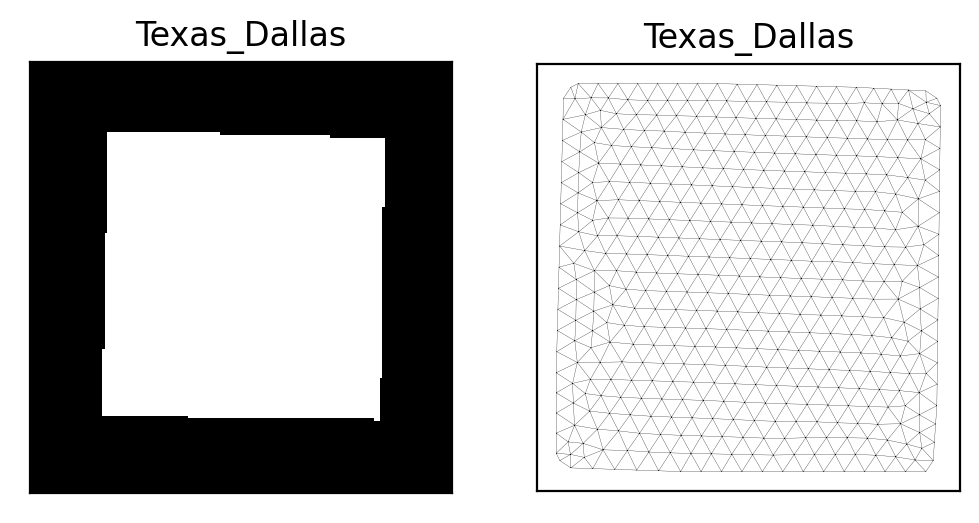

In [33]:
make_mesh('Texas_Dallas', mesh_size=3)

(84, 2)
(224, 305) (84, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 960
  Number of cells:
    line: 114
    triangle: 1804
    vertex: 84
(12, 3, 224, 305)
Building dataset with constant housing in time
Loaded dataset
Model training step 267
Mesh is alright


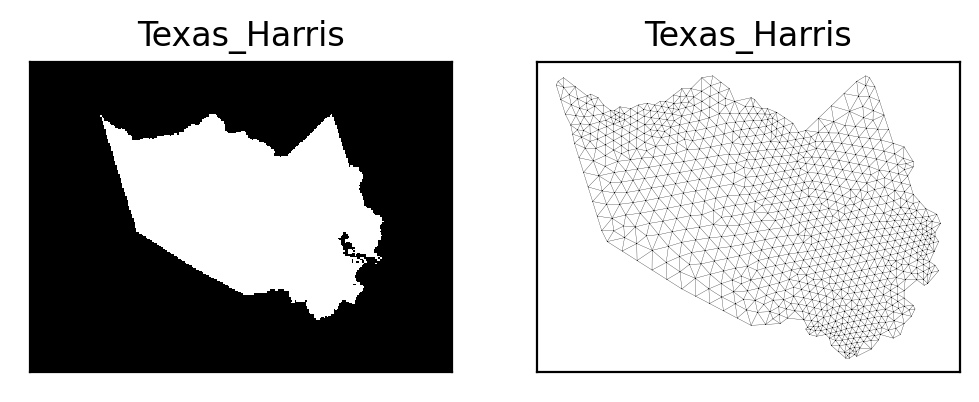

In [34]:
make_mesh('Texas_Harris')

(18, 2)
(152, 147) (18, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 281
  Number of cells:
    line: 61
    triangle: 499
    vertex: 18
could not broadcast input array from shape (152,147) into shape (152)
Removing mesh from library


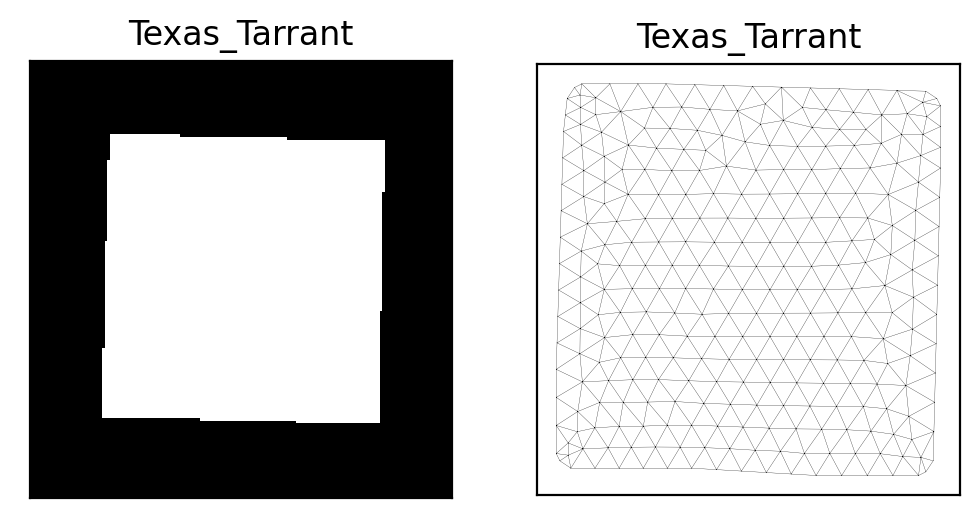

In [35]:
make_mesh('Texas_Tarrant', mesh_size=4)

In [ ]:
make_mesh('Utah_Salt Lake')

(84, 2)
(170, 167) (84, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 849
  Number of cells:
    line: 92
    triangle: 1604
    vertex: 84
(12, 3, 170, 167)
Building dataset with constant housing in time
Loaded dataset
Model training step 152
Mesh is alright


In [ ]:
make_mesh('Virginia_Fairfax', mesh_size=4)

In [ ]:
make_mesh('Washington_King')